In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
import matplotlib.pyplot as plt

In [2]:
# get data from .txt files, and concatenate all dataframes into 1 dataframe
# imdb data was not working well with read_csv data, so read line by line and made a dataframe from a list
imdb_sentence = []
imdb_score = []
with open("imdb_labelled.txt", 'r') as f:
    content = f.readlines()
    content = [x.strip() for x in content] 

for review in content:
    imdb_sentence.append(review.split("\t")[0])
    imdb_score.append(int(review.split("\t")[1]))

df_imdb = pd.DataFrame(list(zip(imdb_sentence, imdb_score))) 
df_yelp = pd.read_csv("yelp_labelled.txt", delimiter="\t", header=None)
df_amazon = pd.read_csv("amazon_cells_labelled.txt", delimiter="\t", header=None)
frames = [df_imdb, df_yelp, df_amazon]
df = pd.concat(frames, ignore_index=True)
df.columns = ['Sentence', 'Score']
#df = df.astype({'Score' : 'int64'}).dtypes

In [4]:
# STEP 1: Feature Construction

# Function:   process_text
# Purpose:    To take in each review and preprocess the data. It will accomplish the folowing:
#             1. Remove punctuations. Punctuation removed are [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
#             2. Remove Stop words. Stop words in NLP are useless words such as "the", "a", "and", etc.
#             3: Stemming text. Words such as "like" and "liked" will be trimmed and treated as the same word
# Input:      
#     text:   A single review, which is a string
# Output:
#     finished_words:   A list of post processed data for the single review
#
def process_text(text):
    
    #1 Remove Punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #2 Remove Stop Words
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    #3: Stemming text
    stemmer = PorterStemmer()
    finished_words = [stemmer.stem(word) for word in clean_words]

    #4 Remove Digits
    
    #4 Return a list of data cleaned words
    return finished_words

In [5]:
# create a vectorizer object, using the process_text function as the means to tokenize the data, and transform the data to an M x N matrix. M being records and N being the number of words
vectorizer = CountVectorizer(analyzer=process_text)
tokenized_matrix = vectorizer.fit_transform(df.Sentence)

In [6]:
# Step 2: Dataset Split
# Will divide data into a training, testing, and split set
# Training: 60%, Testing: 20%, Validation: 20%
X = tokenized_matrix
y = df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# For validation, 80% * 25% = 20%, giving us the desired 60, 20, 20 split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [18]:
# Step 3: Feature Selection
cv = CountVectorizer(analyzer=process_text,max_features=1000)
tokenized_matrix_1000 = cv.fit_transform(df.Sentence)

# train, test, and validation split for the top 1000 feature vector
X_1000_train, X_1000_test, y_1000_train, y_1000_test = train_test_split(X, y, test_size=0.2, random_state=1)

# For validation, 80% * 25% = 20%, giving us the desired 60, 20, 20 split
X_1000_train, X_1000_val, y_1000_train, y_1000_val = train_test_split(X_1000_train, y_1000_train, test_size=0.25, random_state=1)

In [19]:
tokenized_matrix_1000.shape

(3000, 1000)

In [ ]:
# Step 4: Classification Algorithms

In [11]:
# Function:   run_classifier
# Purpose:    To train, predict, and report scoring for a given classifier and its respective data
#             
# Input:      
#     model:   The classifier that will be runned
#     X_train:  training data for sentences
#     y_train:  training data for labels 
#     X_test:   testing data for sentences
#     y_test:   testing data for labels 
#     model_name:   Name of the model, which is a string
# Output:
#     finished_words:   A list of post processed data for the single review
#
def run_classifier(model, X_train, y_train, X_test, y_test, model_name):

    offline_start = time.perf_counter()
    model.fit(X_train, y_train)
    offline_end = time.perf_counter()

    online_start = time.perf_counter()
    prediction = model.predict(X_test)
    online_end = time.perf_counter()

    tp, fp, fn, tn = confusion_matrix(y_test, prediction).ravel()
    specificity = tn / (tn+fp)

    print('Classification Report \n', classification_report(y_test, prediction))
    print()
    print('Confusion Matrix \n', confusion_matrix(y_test, prediction))
    print()
    print('Accuracy: ', accuracy_score(y_test, prediction)*100, '%')
    print()
    print('AUROC: ', roc_auc_score(y_test, prediction))
    print('Specificity: ', specificity)
    print()
    print('Offline efficiency cost: ', offline_end- offline_start, 'seconds')
    print('Online efficiency cost: ', online_end- online_start, 'seconds')
    print()
    # create and print graph - maybe should make this it's own function
    y_score = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, y_score)
    plt.title('ROC - ' + model_name)
    plt.plot(fpr, tpr, label = 'ROC - ' + model_name)
    plt.plot([0,1], ls = '--', label = 'No Skill')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

    print("------------------------------------------------------------------------------------")
    print()

Analysis of Naive Bayes -- All Features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       902
           1       0.94      0.95      0.95       898

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800


Confusion Matrix 
 [[852  50]
 [ 45 853]]

Accuracy:  94.72222222222221 %

AUROC:  0.9472281344599233
Specificity:  0.9446290143964563

Offline efficiency cost:  0.0018232999999554522 seconds
Online efficiency cost:  0.00025649999997767736 seconds



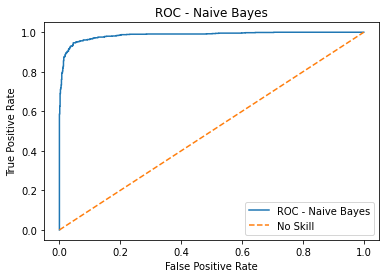

------------------------------------------------------------------------------------


Analysis of Naive Bayes -- All Features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       301
           1       0.79      0.81      0.80       299

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600


Confusion Matrix 
 [[236  65]
 [ 56 243]]

Accuracy:  79.83333333333333 %

AUROC:  0.7983810931232569
Specificity:  0.788961038961039

Offline efficiency cost:  0.0014204999999947177 seconds
Online efficiency cost:  0.0001371999999264517 seconds



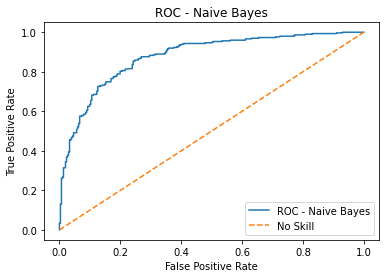

------------------------------------------------------------------------------------


Analysis of Naive Bayes -- All Features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       297
           1       0.76      0.82      0.79       303

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600


Confusion Matrix 
 [[220  77]
 [ 54 249]]

Accuracy:  78.16666666666666 %

AUROC:  0.7812614594792812
Specificity:  0.7638036809815951

Offline efficiency cost:  0.0014353999999912048 seconds
Online efficiency cost:  0.00013939999996637198 seconds



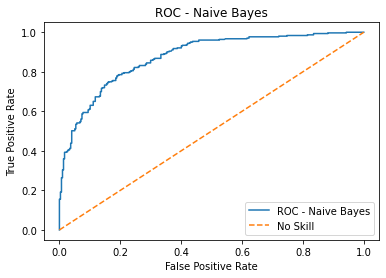

------------------------------------------------------------------------------------



In [9]:
# Classification Algorithm #1: Naive Bayes -- All features
print('Analysis of Naive Bayes -- All Features -- Training Data')
run_classifier(MultinomialNB(), X_train, y_train, X_train, y_train, 'Naive Bayes')
print()
print('Analysis of Naive Bayes -- All Features -- Testing Data')
run_classifier(MultinomialNB(), X_train, y_train, X_test, y_test, 'Naive Bayes')
print()
print('Analysis of Naive Bayes -- All Features -- Validation Data')
run_classifier(MultinomialNB(), X_train, y_train, X_val, y_val, 'Naive Bayes')

Analysis of Naive Bayes -- Top 1000 features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.94      0.95       902
           1       0.94      0.95      0.95       898

    accuracy                           0.95      1800
   macro avg       0.95      0.95      0.95      1800
weighted avg       0.95      0.95      0.95      1800


Confusion Matrix 
 [[852  50]
 [ 45 853]]

Accuracy:  94.72222222222221 %

AUROC:  0.9472281344599233
Specificity:  0.9446290143964563

Offline efficiency cost:  0.001771599999983664 seconds
Online efficiency cost:  0.0002627000000074986 seconds



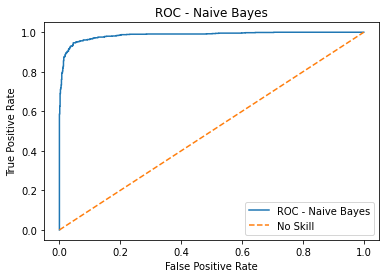

------------------------------------------------------------------------------------


Analysis of Naive Bayes -- Top 1000 features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.78      0.80       301
           1       0.79      0.81      0.80       299

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600


Confusion Matrix 
 [[236  65]
 [ 56 243]]

Accuracy:  79.83333333333333 %

AUROC:  0.7983810931232569
Specificity:  0.788961038961039

Offline efficiency cost:  0.0015511000000287822 seconds
Online efficiency cost:  0.0001401000000669228 seconds



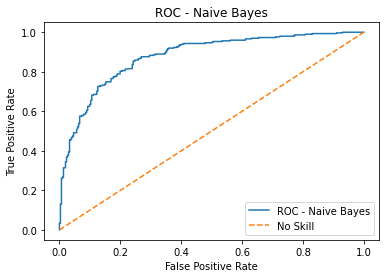

------------------------------------------------------------------------------------


Analysis of Naive Bayes -- Top 1000 features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       297
           1       0.76      0.82      0.79       303

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.78       600
weighted avg       0.78      0.78      0.78       600


Confusion Matrix 
 [[220  77]
 [ 54 249]]

Accuracy:  78.16666666666666 %

AUROC:  0.7812614594792812
Specificity:  0.7638036809815951

Offline efficiency cost:  0.0015004000000544693 seconds
Online efficiency cost:  0.000141299999995681 seconds



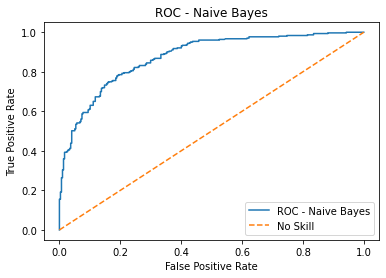

------------------------------------------------------------------------------------



In [12]:
# Classification Algorithm #1: Naive Bayes -- Top 1000 features
print('Analysis of Naive Bayes -- Top 1000 features -- Training Data')
run_classifier(MultinomialNB(), X_1000_train, y_1000_train, X_1000_train, y_1000_train, 'Naive Bayes')
print()
print('Analysis of Naive Bayes -- Top 1000 features -- Testing Data')
run_classifier(MultinomialNB(), X_1000_train, y_1000_train, X_1000_test, y_1000_test, 'Naive Bayes')
print()
print('Analysis of Naive Bayes -- Top 1000 features -- Validation Data')
run_classifier(MultinomialNB(), X_1000_train, y_1000_train, X_1000_val, y_1000_val, 'Naive Bayes')

Analysis of Random Forest Classifier -- All Features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       902
           1       1.00      1.00      1.00       898

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


Confusion Matrix 
 [[902   0]
 [  1 897]]

Accuracy:  99.94444444444444 %

AUROC:  0.9994432071269488
Specificity:  1.0

Offline efficiency cost:  1.827826899999991 seconds
Online efficiency cost:  0.06763880000005429 seconds



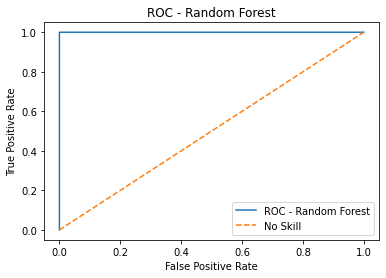

------------------------------------------------------------------------------------


Analysis of Random Forest Classifier -- All Features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       301
           1       0.81      0.78      0.79       299

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600


Confusion Matrix 
 [[245  56]
 [ 66 233]]

Accuracy:  79.66666666666666 %

AUROC:  0.796608851209458
Specificity:  0.8062283737024222

Offline efficiency cost:  1.8027024999998957 seconds
Online efficiency cost:  0.030024700000012672 seconds



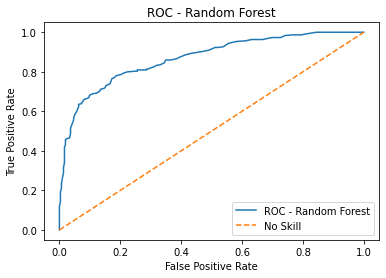

------------------------------------------------------------------------------------


Analysis of Random Forest Classifier -- All Features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78       297
           1       0.79      0.76      0.77       303

    accuracy                           0.78       600
   macro avg       0.78      0.78      0.77       600
weighted avg       0.78      0.78      0.77       600


Confusion Matrix 
 [[236  61]
 [ 74 229]]

Accuracy:  77.5 %

AUROC:  0.7751941860852751
Specificity:  0.7896551724137931

Offline efficiency cost:  1.8064106999999012 seconds
Online efficiency cost:  0.029733500000020285 seconds



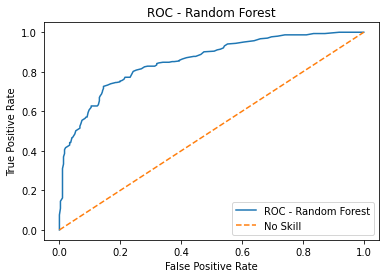

------------------------------------------------------------------------------------



In [14]:
# Classification Algorithm #1: Random Forest Classifier -- All features
print('Analysis of Random Forest Classifier -- All Features -- Training Data')
run_classifier(RandomForestClassifier(), X_train, y_train, X_train, y_train, 'Random Forest')
print()
print('Analysis of Random Forest Classifier -- All Features -- Testing Data')
run_classifier(RandomForestClassifier(), X_train, y_train, X_test, y_test, 'Random Forest')
print()
print('Analysis of Random Forest Classifier -- All Features -- Validation Data')
run_classifier(RandomForestClassifier(), X_train, y_train, X_val, y_val, 'Random Forest')

Analysis of Random Forest Classifier -- Top 1000 Features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       902
           1       1.00      1.00      1.00       898

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


Confusion Matrix 
 [[901   1]
 [  0 898]]

Accuracy:  99.94444444444444 %

AUROC:  0.9994456762749446
Specificity:  0.9988876529477196

Offline efficiency cost:  1.8141246000000137 seconds
Online efficiency cost:  0.06617729999993571 seconds



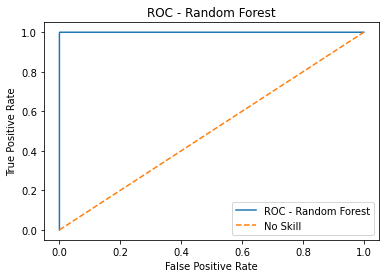

------------------------------------------------------------------------------------


Analysis of Random Forest Classifier -- Top 1000 Features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.80      0.78       301
           1       0.79      0.75      0.77       299

    accuracy                           0.78       600
   macro avg       0.78      0.77      0.77       600
weighted avg       0.78      0.78      0.77       600


Confusion Matrix 
 [[242  59]
 [ 76 223]]

Accuracy:  77.5 %

AUROC:  0.774903054478383
Specificity:  0.7907801418439716

Offline efficiency cost:  1.7948714999999993 seconds
Online efficiency cost:  0.02948079999998754 seconds



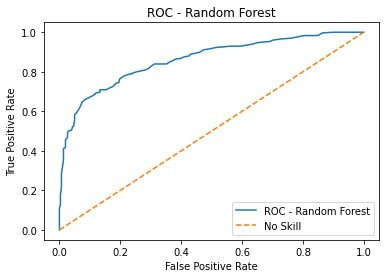

------------------------------------------------------------------------------------


Analysis of Random Forest Classifier -- Top 1000 Features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       297
           1       0.78      0.74      0.76       303

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.76       600
weighted avg       0.77      0.77      0.76       600


Confusion Matrix 
 [[234  63]
 [ 78 225]]

Accuracy:  76.5 %

AUROC:  0.7652265226522652
Specificity:  0.78125

Offline efficiency cost:  1.7850864999999203 seconds
Online efficiency cost:  0.029499500000042644 seconds



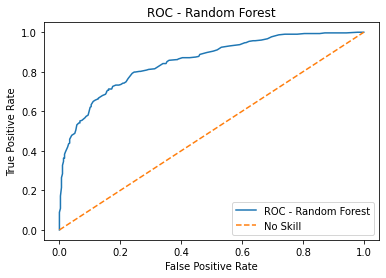

------------------------------------------------------------------------------------



In [15]:
# Classification Algorithm #2: Random Forest Classifier -- Top 1000 Features
print('Analysis of Random Forest Classifier -- Top 1000 Features -- Training Data')
run_classifier(RandomForestClassifier(), X_1000_train, y_1000_train, X_1000_train, y_1000_train, 'Random Forest')
print()
print('Analysis of Random Forest Classifier -- Top 1000 Features -- Testing Data')
run_classifier(RandomForestClassifier(), X_1000_train, y_1000_train, X_1000_test, y_1000_test, 'Random Forest')
print()
print('Analysis of Random Forest Classifier -- Top 1000 Features -- Validation Data')
run_classifier(RandomForestClassifier(), X_1000_train, y_1000_train, X_1000_val, y_1000_val, 'Random Forest')

Analysis of K Nearest Neighbors -- All Features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       902
           1       0.78      0.86      0.82       898

    accuracy                           0.81      1800
   macro avg       0.81      0.81      0.81      1800
weighted avg       0.81      0.81      0.81      1800


Confusion Matrix 
 [[691 211]
 [129 769]]

Accuracy:  81.11111111111111 %

AUROC:  0.8112114133896957
Specificity:  0.7846938775510204

Offline efficiency cost:  0.0013953999999785083 seconds
Online efficiency cost:  0.10727239999994254 seconds



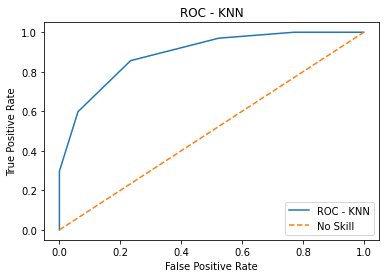

------------------------------------------------------------------------------------


Analysis of K Nearest Neighbors -- All Features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.65      0.69       301
           1       0.68      0.74      0.71       299

    accuracy                           0.70       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.70      0.70      0.70       600


Confusion Matrix 
 [[197 104]
 [ 77 222]]

Accuracy:  69.83333333333334 %

AUROC:  0.6984799831109234
Specificity:  0.6809815950920245

Offline efficiency cost:  0.0005612999999584645 seconds
Online efficiency cost:  0.035805999999979576 seconds



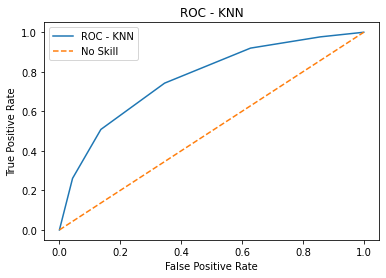

------------------------------------------------------------------------------------


Analysis of K Nearest Neighbors -- All Features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       297
           1       0.68      0.73      0.70       303

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.69       600


Confusion Matrix 
 [[191 106]
 [ 82 221]]

Accuracy:  68.66666666666667 %

AUROC:  0.6862352901956863
Specificity:  0.6758409785932722

Offline efficiency cost:  0.0005442000000357439 seconds
Online efficiency cost:  0.03597339999998894 seconds



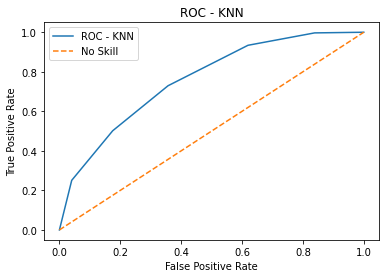

------------------------------------------------------------------------------------



In [16]:
# Classification Algorithm #3: K Nearest Neighbors -- All Features
print('Analysis of K Nearest Neighbors -- All Features -- Training Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_train, y_train, 'KNN')
print()
print('Analysis of K Nearest Neighbors -- All Features -- Testing Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test, 'KNN')
print()
print('Analysis of K Nearest Neighbors -- All Features -- Validation Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_val, y_val, 'KNN')

Analysis of K Nearest Neighbors -- Top 1000 Features -- Training Data
Classification Report 
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       902
           1       0.78      0.86      0.82       898

    accuracy                           0.81      1800
   macro avg       0.81      0.81      0.81      1800
weighted avg       0.81      0.81      0.81      1800


Confusion Matrix 
 [[691 211]
 [129 769]]

Accuracy:  81.11111111111111 %

AUROC:  0.8112114133896957
Specificity:  0.7846938775510204

Offline efficiency cost:  0.0013475999999172927 seconds
Online efficiency cost:  0.10606040000004668 seconds



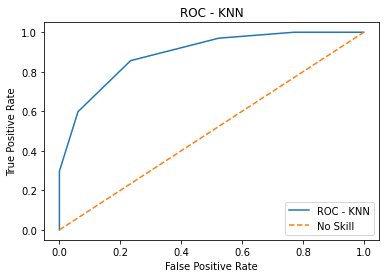

------------------------------------------------------------------------------------


Analysis of K Nearest Neighbors -- Top 1000 Features -- Testing Data
Classification Report 
               precision    recall  f1-score   support

           0       0.72      0.65      0.69       301
           1       0.68      0.74      0.71       299

    accuracy                           0.70       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.70      0.70      0.70       600


Confusion Matrix 
 [[197 104]
 [ 77 222]]

Accuracy:  69.83333333333334 %

AUROC:  0.6984799831109234
Specificity:  0.6809815950920245

Offline efficiency cost:  0.000795700000026045 seconds
Online efficiency cost:  0.03541359999996985 seconds



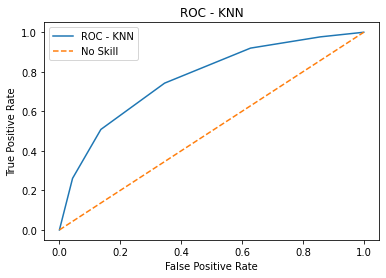

------------------------------------------------------------------------------------


Analysis of K Nearest Neighbors -- Top 1000 Features -- Validation Data
Classification Report 
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       297
           1       0.68      0.73      0.70       303

    accuracy                           0.69       600
   macro avg       0.69      0.69      0.69       600
weighted avg       0.69      0.69      0.69       600


Confusion Matrix 
 [[191 106]
 [ 82 221]]

Accuracy:  68.66666666666667 %

AUROC:  0.6862352901956863
Specificity:  0.6758409785932722

Offline efficiency cost:  0.0008159000000205197 seconds
Online efficiency cost:  0.035597100000018145 seconds



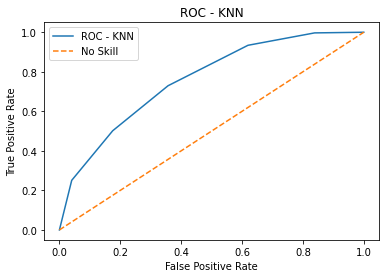

------------------------------------------------------------------------------------



In [17]:
# Classification Algorithm #3: K Nearest Neighbors -- Top 1000 Features
print('Analysis of K Nearest Neighbors -- Top 1000 Features -- Training Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_1000_train, y_1000_train, X_1000_train, y_1000_train, 'KNN')
print()
print('Analysis of K Nearest Neighbors -- Top 1000 Features -- Testing Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_1000_train, y_1000_train, X_1000_test, y_1000_test, 'KNN')
print()
print('Analysis of K Nearest Neighbors -- Top 1000 Features -- Validation Data')
run_classifier(KNeighborsClassifier(n_neighbors=5), X_1000_train, y_1000_train, X_1000_val, y_1000_val, 'KNN')